## Calculate net heat fluxes out of Terra Nova Bay using ERA5 single level hourly data. 

https://cds.climate.copernicus.eu/cdsapp#!/dataset/reanalysis-era5-single-levels?tab=overview

##### Does not include Manuela winds. Will show calculation including Manuela winds later

4/5/2023 Corrected errors found by Hyun A Choi (KyungPook National University). Added UTC to local time conversion (+ 13 hrs) to Local Solar Time calculation. Corrected ds.t2m to ds.sst in calculation of saturation vapor pressure (eTs).  

In [2]:
import os
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
import pandas as pd
import scipy.io as sio
import colorcet as cc
import gsw
import numpy.ma as ma
from matplotlib import ticker
from matplotlib.dates import DateFormatter
%matplotlib inline

In [3]:
#Import 
#https://cds.climate.copernicus.eu/cdsapp#!/yourrequests?tab=form
# Relative humidity should be calculated: RH = 100 * es(Td)/es(T) https://confluence.ecmwf.int/display/CKB/ERA-Interim%3A+documentation
#era5 = xr.open_dataset('D:\Projects\TNB 2018\Data\ERA5\ETA5_1990_2000.nc')
#era5 = xr.open_dataset('D:\Projects\TNB 2018\Data\ERA5\ERA5_2000_2007.nc')
era5 = xr.open_dataset('D:\Projects\TNB 2018\Data\ERA5\ERA5_2008_2015.nc')
#era5 = xr.open_dataset('D:\Projects\TNB 2018\Data\ERA5\ERA5_2016_2021.nc')

era5

<xarray.Dataset>
Dimensions:    (latitude: 41, longitude: 1321, time: 11688)
Coordinates:
  * longitude  (longitude) float32 -160.0 -159.8 -159.5 ... 169.5 169.8 170.0
  * latitude   (latitude) float32 -70.0 -70.25 -70.5 ... -79.5 -79.75 -80.0
  * time       (time) datetime64[ns] 2008-01-01 ... 2015-12-31T18:00:00
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 ...
    d2m        (time, latitude, longitude) float32 ...
    t2m        (time, latitude, longitude) float32 ...
    lsm        (time, latitude, longitude) float32 ...
    msl        (time, latitude, longitude) float32 ...
    siconc     (time, latitude, longitude) float32 ...
    sst        (time, latitude, longitude) float32 ...
    skt        (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-02-28 06:06:45 GMT by grib_to_netcdf-2.24.2: /opt/ecmw...

In [4]:
#subset of Terra Nova Bay
#era5_tnb = era5.sel(latitude=np.arange(-75.3,-74.5,0.25),longitude=np.arange(163.5,166.5,0.25), method='nearest')
era5_tnb = era5.sel(latitude=np.arange(-75.3,-74.66,0.25),longitude=np.arange(163.5,167,0.25), method='nearest')
era5_ross = era5.sel(latitude=np.arange(-78.5,-50.5,0.25),longitude=np.arange(155,220,0.25), method='nearest') #for context

In [5]:
#era5_tnb.to_netcdf('D:\Projects\TNB 2018\Data\ERA5\processed.nc')

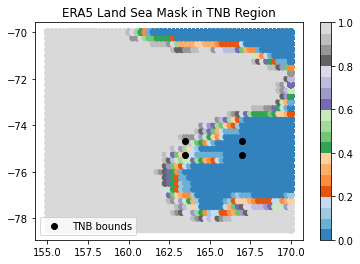

In [6]:
#Look at masked study domain
# lsm variable
# "grid boxes where this parameter has a value above 0.5 can be comprised of a mixture of land and inland water but not ocean"

X,Y = np.meshgrid(era5_ross.sel(time='2008-01').longitude,era5_ross.sel(time='2008-01').latitude)

plt.scatter(X,Y,c=era5_ross.sel(time='2008-01').lsm.mean(dim='time'),vmax=1,cmap='tab20c')
plt.colorbar()
plt.title('ERA5 Land Sea Mask in TNB Region')

plt.scatter(np.array([163.5, 163.5, 167, 167]),np.array([-75.3, -74.66, -75.3, -74.66]),c='k', label='TNB bounds')
# tmp = era5_tnb.where(era5_tnb.lsm<0.5) 
plt.legend()
# X,Y = np.meshgrid(tmp.sel(time='2008-01').longitude,tmp.sel(time='2008-01').latitude)
# plt.scatter(X,Y, c=tmp.sel(time='2008-01-01').lsm.mean(dim='time'), cmap='Reds')
# plt.colorbar()


In [7]:
#average over study area
ds = era5_tnb.where(era5_tnb.lsm<0.5).mean(dim=['longitude','latitude']) #Mask out land and averager over TNB
ds

<xarray.Dataset>
Dimensions:  (time: 11688)
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01 ... 2015-12-31T18:00:00
Data variables:
    u10      (time) float32 6.686 2.436 -1.266 -1.925 ... 2.768 2.021 4.854
    v10      (time) float32 2.532 2.478 2.156 1.13 ... 6.5 6.687 3.676 2.012
    d2m      (time) float32 263.7 266.2 266.3 265.8 ... 267.4 266.3 265.6 262.3
    t2m      (time) float32 270.0 270.7 269.7 269.4 ... 271.0 271.0 270.5 268.7
    lsm      (time) float32 0.08944 0.08944 0.08944 ... 0.08944 0.08944 0.08944
    msl      (time) float32 9.902e+04 9.908e+04 9.93e+04 ... 9.941e+04 9.919e+04
    siconc   (time) float32 0.3377 0.3377 0.3377 0.3377 ... 0.1116 0.1116 0.1116
    sst      (time) float32 272.1 272.1 272.1 272.1 ... 273.1 273.1 273.1 273.1
    skt      (time) float32 271.7 271.8 270.9 271.1 ... 272.9 272.8 271.9 271.8
    tcc      (time) float32 0.5352 0.8336 0.9948 0.9135 ... 0.9987 0.949 0.1756

# Shortwave radiation ($Q_{s}$)

In [29]:
# C_c, cloud cover correction
alpha1 = 1
alpha2 = 0.6
alpha3 = 3
alpha4 = 0

C_c = np.expand_dims(alpha1 - alpha2*ds.tcc**alpha3, axis = 0) #cloud cover is dimensionaless
#C_c = np.expand_dims(alpha1 - alpha2*tmp.cc**alpha3, axis = 0) #use pressure level cloud cover
C_c = C_c[0]
C_c

array([0.90800047, 0.6524683 , 0.40936613, ..., 0.4024195 , 0.48725003,
       0.99675375], dtype=float32)

<img src= "https://3.bp.blogspot.com/-7WOLq00rj0k/Tc714sHrFRI/AAAAAAAAB_s/YuLcSM1hMy8/s1600/zenith1.jpg" width="500" height="600">

In [51]:
#https://www.myroms.org/wiki/Radiant_Heat_Fluxes
#Marcus 1998
latitude = -75
longitude = 165
declination = 23.44 * np.cos((172 - pd.to_datetime(era5.time.values).day_of_year) * 2*np.pi/365)

LSTM = 15 * 13 #https://www.pveducation.org/pvcdrom/properties-of-sunlight/solar-time
B = 360/365 * (pd.to_datetime((era5.time + pd.Timedelta(hours=13)).values).day_of_year - 81) # pd.Timedelta(hours=13): Convert from ERA5 time (UTC) to local time (UTC + 13 hours)
EoT = 9.87 * np.sin(np.radians(2*B)) - 7.53*np.cos(np.radians(B)-1.5*np.sin(np.radians(B))) #Equation of Time
TC = 4 * (longitude - LSTM) + EoT #Time Correction
LST = pd.to_datetime((era5.time + pd.Timedelta(hours=13)).values).hour + TC/60 #Local Solar Time  # pd.Timedelta(hours=13): Convert from ERA5 time (UTC) to local time (UTC + 13 hours)
HA = 15 * (LST-12)

cosZ = np.sin(np.radians(latitude))*np.sin(np.radians(declination)) + np.cos(np.radians(latitude))*np.cos(np.radians(declination))*np.cos(np.radians(HA))
cosZ = ma.masked_less(cosZ,0)

In [52]:
#eT Water vapor pressure
#eTs Saturation vapor pressure

eT = 611 * 10**(7.5*(ds.d2m-273.16)/(ds.d2m-35.86)) # simonsen and haugen. Units of Pa https://www.myroms.org/wiki/Radiant_Heat_Fluxes
eTs = 611 * 10**(7.5*(ds.sst-273.16)/(ds.sst-35.86))  #parkinson washington # 4/5/2023 Corrected from ds.t2m to ds.sst

In [53]:
#T_r transmittance of the clear sky atmosphere

T_r = cosZ/(cosZ+((1 + cosZ)*eT*10**-5)+0.046)
T_r 

masked_array(data=[0.9224349560577131, 0.8977404412271116,
                   0.7497365201828837, ..., 0.8978483970412483,
                   0.7520078782196785, 0.8605726492102276],
             mask=[False, False, False, ..., False, False, False],
       fill_value=1e+20)

In [54]:
S_a = np.expand_dims(1.353 * 1000,axis=0) #watts per square metre

<AxesSubplot:xlabel='time'>

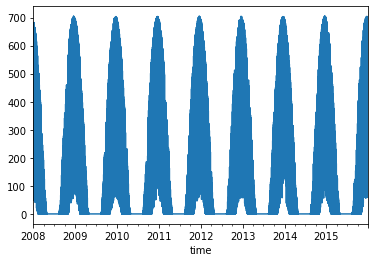

In [55]:
#Q_s = (1-0.08)*C_c*T_r*S_a*np.cos(eta_rad) #Simonson & haugan use alpha =0.06 for open water, so 0.08 seems right

Q_s = (1-0.08)*C_c*T_r*S_a*cosZ #Simonson & haugan use alpha =0.06 for open water, so 0.08 seems right
#Q_s = S_a * cosZ**2/((cosZ+2.7)*eT*10**-5+1.085*cosZ+0.1)
df = pd.DataFrame({'time':pd.to_datetime(era5.time.values), 'Q_s': Q_s}) #, 'C_c': C_c.squeeze(), 'T_r': T_r.squeeze(), 'cos_eta': np.cos(eta)})
df.Q_s = df.Q_s.fillna(0)
df = df.set_index('time')
df.Q_s.plot()

# Longwave ($Q_{b}$)

In [56]:
epsilon = 0.95 # ocean emissivity https://www.tandfonline.com/doi/pdf/10.1080/07055900.1991.9649392
sigma = 5.670367 * 10**-8 # W m−2 K−4
e_m = 0.7829*(1 + 0.2232*ds.tcc**2.75)

Q_b = 4 * epsilon * sigma * ds.t2m**3*(ds.t2m - ds.sst) + epsilon * sigma * ds.t2m**4*(0.39-0.05*(eT)**.5)*(1-0.82*ds.tcc**2)
           # upwelling (negative)                          #downwelling (positive)
# Budillon shows addition, Parkinson and Washington show subtraction. based on signs, I think its addition
# Also, budillon says 0.05 and PW says 0.005

#0.82 for 75degrees. from table in Budyko 

#Q_b2 = sigma * (epsilon * 271.16**4 - e_m*ds.t2m**4)
df = df.assign(Q_b = Q_b)
#df = df.assign(Q_b2 = Q_b2)

<AxesSubplot:xlabel='time'>

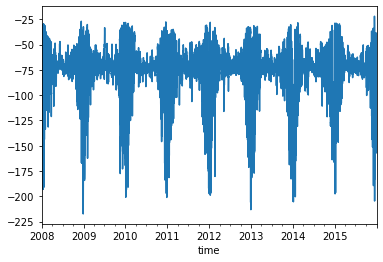

In [57]:
df.Q_b.plot()

# Sensible ($Q_{H}$)

In [58]:
#Following Parkinson and Washington
#rho_a = ds.msl/(286 * ds.t2m) #kg/m^3 #Density of dry air P/RT #https://www.grc.nasa.gov/WWW/k-12/airplane/eqstat.html
mixing_ratio = 621.97*(eT/100)/(ds.msl/100-(eT/100)) #https://www.weather.gov/media/epz/wxcalc/mixingRatio.pdf
virtual_temp = ds.t2m + mixing_ratio/6
rho_a = ds.msl/(287.05 * virtual_temp) #density of MOIST air https://www.usna.edu/Users/oceano/barrett/SO414/Lesson2.pdf
V = np.sqrt(ds.u10**2 + ds.v10**2)
c_p = 1004 #J kg K
C_h = 1.1e-3  #1.75e-3 #Budillon, Simonsen & Haugan, Maykut #1.1e-3

Q_H = rho_a * c_p * C_h * V * (ds.t2m - ds.sst)
df = df.assign(Q_H = Q_H)

Q_H_maycut = rho_a * c_p * 1.75e-3 * V * (ds.t2m - ds.sst)
df = df.assign(Q_H_maycut = Q_H_maycut)

<AxesSubplot:xlabel='time'>

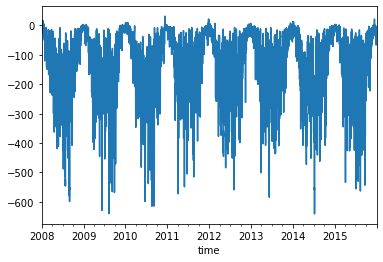

In [59]:
df.Q_H.plot()

# Latent ($Q_{E}$)

In [60]:
L_E = 2.5e6 # Parkinson and WAshington, simonson
C_E = 1.1e-3  #1.75e-3  #1.1e-3 
q_10m = 0.622*eT/(ds.msl-0.378*eT)
q_s = 0.622*eTs/(ds.msl-0.378*eTs)

Q_E = rho_a * L_E * C_E * V * (q_10m - q_s)
df = df.assign(Q_E = Q_E)

Q_E_maycut = rho_a * L_E * 1.75e-3 * V * (q_10m - q_s)
df = df.assign(Q_E_maycut = Q_E_maycut)

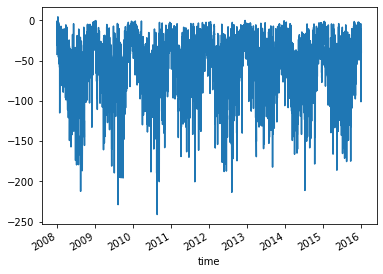

In [61]:
Q_E.plot()

# Total $Q_{net}$ 

In [62]:
Q_net = df.Q_s + df.Q_b + df.Q_H + df.Q_E
df = df.assign(Q_net = Q_net)
df.groupby(df.index.year).mean()
df = df.assign(Q_net = Q_net)

Q_net_maycut = df.Q_s + df.Q_b + df.Q_H_maycut + df.Q_E_maycut
df = df.assign(Q_net_maycut = Q_net_maycut)
df.groupby(df.index.year).mean()
df = df.assign(Q_net_maycut = Q_net_maycut)

<AxesSubplot:xlabel='time'>

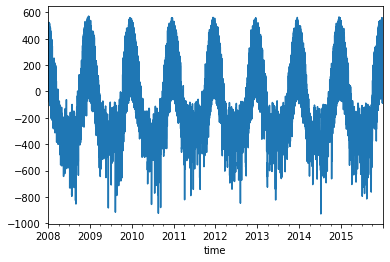

In [64]:
df.Q_net.plot()

# Combine all years

In [65]:
df_all = []
directory='D:/Projects/TNB 2018/Data/ERA5/'
varnames=[]
for filename in os.listdir(directory):
    #print(filename)
    if filename.endswith(".csv"):
        print(filename)
        file=os.path.splitext(os.path.basename(filename))[0]
        varnames.append(file)
print(varnames)
for i in np.arange(0,(len(varnames))):
    
    tmp = pd.read_csv('D:/Projects/TNB 2018/Data/ERA5/' + varnames[i] + '.csv')#.dropna(dim='time')
    print(i)
    if i == 0:
        df_all = tmp
    else:
        df_all = pd.concat([df_all,tmp])
df_all = df_all.set_index('time')

df_all_.csv
ETA5_1990_2000_avgs.csv
ETA5_2000_2007_avgs.csv
ETA5_2008_2015_avgs.csv
ETA5_2016_2021_avgs.csv
['df_all_', 'ETA5_1990_2000_avgs', 'ETA5_2000_2007_avgs', 'ETA5_2008_2015_avgs', 'ETA5_2016_2021_avgs']
0
1
2
3
4


In [4]:
df_all.to_csv('D:\Projects\TNB 2018\Data\ERA5\df_all_.csv')